<a href="https://colab.research.google.com/github/NelliRishitha/Hackathon2025_T051/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🧑 Detected 5 face(s) using OpenCV DNN.
✅ Sufficient trainees present.


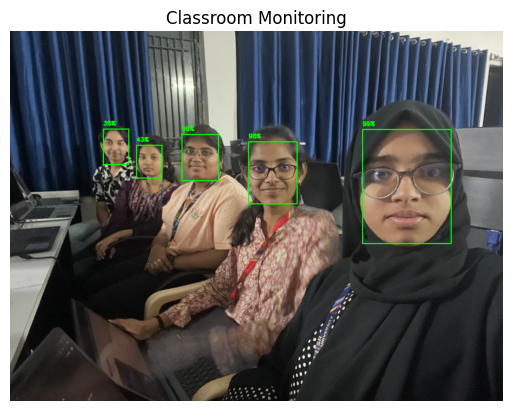

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🧠 Top Predictions:
1. abaya (33.96%)
2. ski_mask (29.76%)
3. mask (5.31%)


In [9]:
!pip install mediapipe
import os
import sys

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.stderr = open(os.devnull, 'w')

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights='imagenet')

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def predict_activity(img_path):
    img = preprocess_image(img_path)
    preds = model.predict(img)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=3)[0]
    print("\n🧠 Top Predictions:")
    for i, (imagenet_id, label, confidence) in enumerate(decoded_preds):
        print(f"{i+1}. {label} ({confidence*100:.2f}%)")

def detect_faces_opencv(img_path, proto_path, model_path):
    image = cv2.imread(img_path)
    if image is None:
        print("❌ Could not read the image.")
        return None

    h, w = image.shape[:2]

    # Load OpenCV face detection model
    net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()

    face_count = 0

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:  # 🔽 Lowered threshold to detect more faces
            face_count += 1
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{int(confidence * 100)}%"
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Feedback
    print(f"\n🧑 Detected {face_count} face(s) using OpenCV DNN.")
    if face_count == 0:
        print("⚠️ Alert: No people detected! Flagging for review.")
    elif face_count < 3:
        print("⚠️ Warning: Very few trainees detected. Needs review.")
    else:
        print("✅ Sufficient trainees present.")

    return image

def show_image_with_prediction(img_path, proto_path, model_path):
    img_with_faces = detect_faces_opencv(img_path, proto_path, model_path)
    if img_with_faces is None:
        return
    img_rgb = cv2.cvtColor(img_with_faces, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Classroom Monitoring")
    plt.show()

    predict_activity(img_path)

# ✅ Input paths
image_path = "/content/classroom5.jpg"
proto_path = "/content/deploy.prototxt"
model_path = "/content/res10_300x300_ssd_iter_140000_fp16.caffemodel"

# 🚀 Run the pipeline
show_image_with_prediction(image_path, proto_path, model_path)
